In [1]:
__author__ = 'Yikangshi "Anthony" Xu <xuyikangshi@noirlab.edu>' # single string; emails in <>
__version__ = '20240523' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['DES_Y3_nz']  # datasets used in this notebook
__keywords__ = [''] # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/astro-datalab/notebooks-latest/blob/master/keywords.txt

# simulation based inferences - generating data vectors for parameter compression

student: Anthony Xu

mentor: Marco Gatti

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [First chapter](#chapter1)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
The goal is to give contraint on paramters like H0 and sigma_8, but for the time being is only able to generate data vectors (angular power spectrum for galaxy-galaxy clustering based on source distribution from DES Y3)

# Summary

For now, data vectors of galaxy-galaxy clustering angular power spectrum was built from initilized sets of parameters. They are intended to be used to train neural density estimator, and to predict parameter posterior distribution function based on observed data.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import healpy as hp
import inspect
sys.path.append('../code/')
from Theory_camb import theory,cosmo

# Part 1 Generate $C_l$ as data vectors from initialized conditions

First, we will choose to initialize one set of parameters, and generate one set of data vectors from it using camb. The parameter values are chosen as follows.

In [3]:
# choose some cosmological parameters
h = 0.67
s8 = 0.84
om = 0.26
ob = 0.0493
ns = 0.9649
mv = 0.02

info() is a function defined to quickly view information about an array.

In [4]:
def info(x):
    print(type(x))
    print(len(x))
    print(np.shape(x))
    print(x)
    return

Next, data is loaded from DES Y3. Here, the data has already been downloaded, and stored in the data folder in this repository.

Data contains information about galaxy number density as a function of redshift $n(z)$, which is the source distribution function. Galaxies are categorized in 4 redshift bins. This way, we can compute galaxy-galaxy clustering angular power spectrum $C_l$ for different redshift bins. This would increase the dimensionality of our data vector. 

A plot of the four redshift bins are shown below. The dimensionality and other information of desy3_nz data are printed.

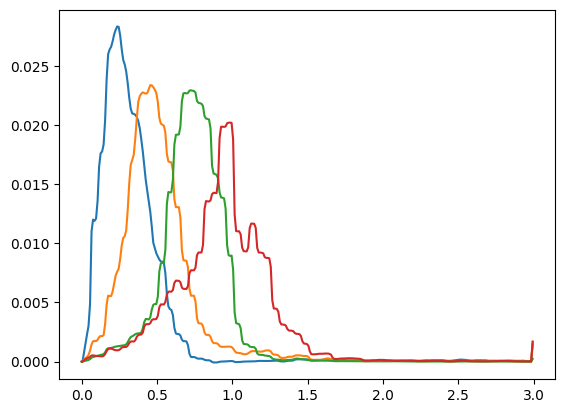

In [5]:
# load redshift distributions (from DES Y3) and plot them.
# DES Y3 weak lensing catalog is divided into 4 redshift bins
desy3_nz = np.loadtxt('../data/des_y3_nz.txt')
for i in range(4):
    mask_bin = desy3_nz[:,0] == i
    plt.plot(desy3_nz[mask_bin,1],desy3_nz[mask_bin,2])
    

In [6]:
info(desy3_nz) # first column is bin number, second column is redshift z, third column is number density n

<class 'numpy.ndarray'>
1204
(1204, 3)
[[0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 5.000e-03 1.335e-05]
 [0.000e+00 1.500e-02 7.880e-04]
 ...
 [3.000e+00 2.975e+00 2.265e-05]
 [3.000e+00 2.984e+00 2.295e-05]
 [3.000e+00 2.994e+00 1.681e-03]]


With the previous set of parameters initialized, we can create Cosmo and Theory objects using cosmo and theory Class in Theory_camb package.

In [7]:
# initialise theory code
Cosmo = cosmo(H0=h*100., ombh2=ob*h**2, omch2=(om-ob)*h**2,As = 2e-9,ns=ns,mnu=mv,num_massive_neutrinos=3 )
Theory = theory( cosmo= Cosmo,halofit_version='takahashi', sigma_8 = s8, fast = False, max_zs = 4., lmax = 2000)


Om_b h^2             =  0.022131
Om_c h^2             =  0.094583
Om_nu h^2            =  0.000215
Om_darkenergy        =  0.739466
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.260479
100 theta (CosmoMC)  =  1.008790
N_eff (total)        =  3.044000
 3 nu, g= 3.0440 m_nu*c^2/k_B/T_nu0=     39.46 (m_nu=  0.007 eV)
Age of universe/GYr  =  14.625
zstar                =  1087.90
r_s(zstar)/Mpc       =  151.78
100*theta            =  1.009025
DA(zstar)/Gpc        =  15.04181
zdrag                =  1057.46
r_s(zdrag)/Mpc       =  154.70
k_D(zstar) Mpc       =  0.1330
100*theta_D          =  0.157091
z_EQ (if v_nu=1)     =  2789.48
k_EQ Mpc (if v_nu=1) =  0.008513
100*theta_EQ         =  0.914901
100*theta_rs_EQ      =  0.501329
tau_recomb/Mpc       =  295.00  tau_now/Mpc =  15336.7
Om_b h^2             =  0.022131
Om_c h^2             =  0.094583
Om_nu h^2            =  0.000215
Om_darkenergy        =  0.739466
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.260479


To apply Theory_camb method to calculate power spectrum, we need to first rearrange $n(z)$ data. This step extracted redshifts for bin 0.

In [8]:
# stack n(z)s in a format that our theory code will like (z,nz1,nz2,nz3,nz4)
nzs = []
bin_0_index_1 = desy3_nz[desy3_nz[:, 0]==0, 1] # shape 301, as it should be
# create list containing this array of length 301 (total number is 1204, but only find bin 1, so only 301)
nzs.append(desy3_nz[desy3_nz[:, 0]==0, 1]) # find where desy3_nz are in bin 0, and appended redshift z to the list. result would be a list containing index 1 of desy3_nz, in bin 0

In [9]:
max_zs = 4
zs = np.linspace(0,max_zs,int(2401*max_zs/12.))

Then we looped through the bins, and extracted normalized number density information from the four bins, adding them to the list. We took $$\tilde{n} = \frac{n(z)}{\int_{0}^{1}{n(z)} \, dz}$$ as normalization.

In [10]:
n_bins = 4 # number of bins is 4
for i in range(n_bins):
    mask_bin = desy3_nz[:,0] == i # find mask of the bins 0, 1, 2, 3
    # normalise and append
    nzs.append(desy3_nz[mask_bin, 2] / np.trapz(desy3_nz[mask_bin, 1] * desy3_nz[mask_bin, 2], desy3_nz[mask_bin, 1]))
    # compute n / integral(z*n*dz), then add to list nzs
nzs = np.array(nzs).T

Next, we need to initilize the lensing kernel for our redshift distribuions by calulcating the weight function. This would first calculate comoving distance corresponding to each redshift value, and then compute the power spectrum of matter density fluctuation using $$P(k) = \frac{9}{4} \Omega_m^2 \left(\frac{H_0}{c}\right)^4 \int_{0}^{\Chi_lim} \frac{g(\Chi)^2}{a(\Chi)^2}P_\delta (k, \Chi) d\Chi$$
Where $k$ is wavenumber and $\Chi$ is comoving radial distance.

Knowing the matter density power spectrum, we can compute the anular power spectrum using Limber approximation $$C_l = \int_{0}^{\infty} P(k = \frac{l + 0.5}{r(z)}, z) \left(\frac{dn_i}{dz} \frac{dn_j}{dz}\right)\frac{dz}{H(z)}$$
Where $l$ is angular scale measured in monopole number.

In [11]:
# initialise the lensing kernel for our redshift distributions
Theory.get_Wshear(nzs)   # return the weight function of shear; output Theory.Wshear

# compute cls ---------------------------
Theory.limber(xtype = 'gg',nonlinear=True)  # output is Theory.clgg

nbins g1 = 4
nbins g2 = 4
Om_b h^2             =  0.022131
Om_c h^2             =  0.094583
Om_nu h^2            =  0.000215
Om_darkenergy        =  0.739466
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.260479
100 theta (CosmoMC)  =  1.008790
N_eff (total)        =  3.044000
 3 nu, g= 3.0440 m_nu*c^2/k_B/T_nu0=     39.46 (m_nu=  0.007 eV)
Age of universe/GYr  =  14.625
zstar                =  1087.90
r_s(zstar)/Mpc       =  151.78
100*theta            =  1.009026
DA(zstar)/Gpc        =  15.04181
zdrag                =  1057.46
r_s(zdrag)/Mpc       =  154.70
k_D(zstar) Mpc       =  0.1330
100*theta_D          =  0.157091
z_EQ (if v_nu=1)     =  2789.48
k_EQ Mpc (if v_nu=1) =  0.008513
100*theta_EQ         =  0.914901
100*theta_rs_EQ      =  0.501329
tau_recomb/Mpc       =  295.02  tau_now/Mpc =  15336.7
100.0% | [##########] | Progress: 2000 / 2000 | Time: 1.0s | ETA: --           

Printed below is the weight function.

In [12]:
Wshear = Theory.Wshear
info(Wshear)

<class 'numpy.ndarray'>
798
(798, 4)
[[1.90983887e-06 1.24266349e-06 8.74691450e-07 6.94906274e-07]
 [3.74182440e-06 2.46107133e-06 1.74069280e-06 1.38440838e-06]
 [5.49565210e-06 3.65496924e-06 2.59784896e-06 2.06841968e-06]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


Printed below is the angular power spectrum of galaxy-galaxy clustering obtained from Limber approximation.

In [13]:
clgg = Theory.clgg
info(clgg) # angular power spectrum

<class 'numpy.ndarray'>
4
(4, 4, 2001)
[[[0.00000000e+00 1.16996936e-07 1.19792265e-07 ... 8.05574020e-11
   8.04839552e-11 8.04106042e-11]
  [0.00000000e+00 9.18872891e-08 9.80801475e-08 ... 9.07499457e-11
   9.06703202e-11 9.05907949e-11]
  [0.00000000e+00 7.12771097e-08 7.77658498e-08 ... 8.89874264e-11
   8.89118983e-11 8.88364627e-11]
  [0.00000000e+00 5.81459636e-08 6.38384917e-08 ... 7.94345262e-11
   7.93682545e-11 7.93020631e-11]]

 [[0.00000000e+00 9.18872891e-08 9.80801475e-08 ... 9.07499457e-11
   9.06703202e-11 9.05907949e-11]
  [0.00000000e+00 7.51714164e-08 8.42040465e-08 ... 1.12647815e-10
   1.12553330e-10 1.12458958e-10]
  [0.00000000e+00 6.00789304e-08 6.91457465e-08 ... 1.19779041e-10
   1.19682510e-10 1.19586092e-10]
  [0.00000000e+00 4.94976519e-08 5.74264582e-08 ... 1.09591556e-10
   1.09504834e-10 1.09418211e-10]]

 [[0.00000000e+00 7.12771097e-08 7.77658498e-08 ... 8.89874264e-11
   8.89118983e-11 8.88364627e-11]
  [0.00000000e+00 6.00789304e-08 6.91457465e-08 

The angular power spectrum calculated in this way of galaxy-galaxy clustering is a measurement of covariance in number density of galaxies from different redshift bins, as a function of angular scale measured by the monople number $l$. Below is a plot of these angular power spectrum from a combination of redshift bins. This are to become the data vector we want to generate.

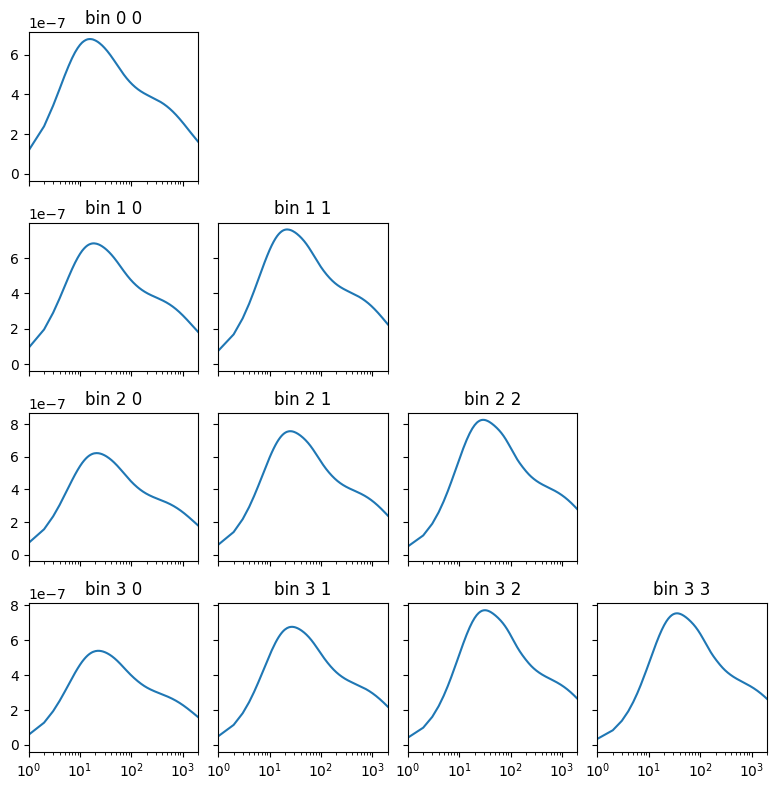

In [14]:

# Initialize the figure and axes
fig, axs = plt.subplots(4, 4, figsize=(8, 8),sharex=True,sharey='row')

# Loop through all subplots to modify them
for i in range(n_bins):
    for j in range(n_bins):
        # Only plot cells where i >= j
        if i >= j:
            # Plot a simple bar or image; here, we're using text for simplicity
            axs[i, j].plot(Theory.clgg[i,j] * np.arange(2001)) # galaxy-galaxy lensing power spectrum
            axs[i, j].set_title('bin {0} {1}'.format(i,j))
           # axs[i, j].set_xticks([])  # Remove x-axis ticks
           # axs[i, j].set_yticks([])  # Remove y-axis ticks
        else:
            # Clear the axis if i < j
            axs[i, j].axis('off')
        axs[i,j].set_xscale('log')
# Adjust layout to prevent overlap
plt.tight_layout()
plt.xlim([1,2000])

plt.show()

Data vector was built from the angular power spectrums we obtained. For each group of bins of redshift, we chose to choose 20 angular power spectrum values. There are 10 combination of redshift bins, which makes up a data vector of dimension 200.

In [15]:
# let's select the cls only at a few multipole values, and make a datavector
l = (10**np.linspace(np.log10(10), np.log10(1990), 20)).astype(int)

t1 = []
ll = []
t2 = []
cl_DV = []
for i in range(n_bins):
    for j in range(n_bins):
        # Only plot cells where i >= j
        if i >= j:
            cl_DV.extend(Theory.clgg[i,j][l])
            t1.extend([i]*len(l))
            t2.extend([j]*len(l)) 
            ll.extend(l) 
            

Finally, noise was added to the power spectrum, generated from a convariance matrix. The result is a plot of this data vector of length 200.

In [16]:
def kd(i, j):
    return 1 if i == j else 0

# desy3 numbers
sigma_eff = 0.26
n_eff_per_bin = 5.12/4. 
f_sky = 0.12

c = sigma_eff**2/(n_eff_per_bin *3600 * 3282.0)

cov = np.zeros((len(cl_DV),len(cl_DV)))
for index1 in range(len(cl_DV)):
    for index2 in range(len(cl_DV)):
        if index1 == index2:
            i = t1[index1]
            j = t2[index1]
            k = t1[index2]
            l = t2[index2]
            l_ = ll[index2]
            cov[index1,index2] = (1./(f_sky*(2*l_+1)))* ((Theory.clgg[i,j][l_] + kd(i,j)*c)*(Theory.clgg[j,l][l_] + kd(j,l)*c)+(Theory.clgg[i,l][l_] + kd(i,l)*c)*(Theory.clgg[j,k][l_] + kd(j,k)*c))
            
            

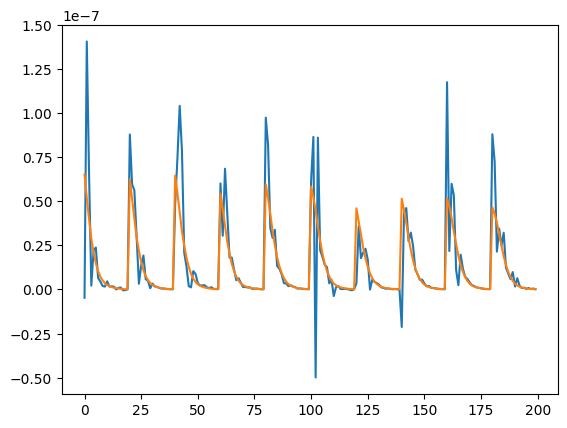

In [17]:
noisy_DV = cl_DV + np.random.normal(0,np.sqrt(cov.diagonal()))
plt.plot(noisy_DV)
plt.plot(cl_DV)

The above process was compressed down to a loop. Current capacity only allowed for the generation of a few data vectors. Otherwise it takes very long.

In [18]:
n_dv = 10

In [19]:
s8_range = np.random.uniform(low = 0.64, high = 1.04, size = 100)
om_range = np.random.uniform(low = 0.16, high = 0.36, size = 100)
params = np.array([])

for count in range(n_dv):
    s8 = s8_range[count]
    om = om_range[count]
    Cosmo = cosmo(H0=h*100., ombh2=ob*h**2, omch2=(om-ob)*h**2,As = 2e-9,ns=ns,mnu=mv,num_massive_neutrinos=3 )
    Theory = theory( cosmo= Cosmo,halofit_version='takahashi', sigma_8 = s8, fast = False, max_zs = 4., lmax = 2000)
    nzs = []
    bin_0_index_1 = desy3_nz[desy3_nz[:, 0]==0, 1] 
    nzs.append(desy3_nz[desy3_nz[:, 0]==0, 1])
    n_bins = 4 

    for i in range(n_bins):
        mask_bin = desy3_nz[:,0] == i
        nzs.append(desy3_nz[mask_bin, 2] / np.trapz(desy3_nz[mask_bin, 1] * desy3_nz[mask_bin, 2], desy3_nz[mask_bin, 1]))

    nzs = np.array(nzs).T
    
    Theory.get_Wshear(nzs) 
    Theory.limber(xtype = 'gg',nonlinear=True)

    l = (10**np.linspace(np.log10(10), np.log10(1990), 20)).astype(int)
    cl_DV = []
    for i in range(n_bins):
        for j in range(n_bins):
            if i >= j:
                cl_DV.extend(Theory.clgg[i,j][l])

    params_tmp = np.array([om, s8])

    if count == 0:
        params = np.array([om, s8])
        dv = np.array(cl_DV)

    else:
        params = np.vstack((params, np.array([om, s8])))
        dv = np.vstack((dv, np.array(cl_DV)))

    
data = {"params": params, "final_dv": dv}

Om_b h^2             =  0.022131
Om_c h^2             =  0.100970
Om_nu h^2            =  0.000215
Om_darkenergy        =  0.725239
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.274706
100 theta (CosmoMC)  =  1.017228
N_eff (total)        =  3.044000
 3 nu, g= 3.0440 m_nu*c^2/k_B/T_nu0=     39.46 (m_nu=  0.007 eV)
Age of universe/GYr  =  14.413
zstar                =  1088.50
r_s(zstar)/Mpc       =  149.86
100*theta            =  1.017454
DA(zstar)/Gpc        =  14.72931
zdrag                =  1057.96
r_s(zdrag)/Mpc       =  152.74
k_D(zstar) Mpc       =  0.1349
100*theta_D          =  0.158127
z_EQ (if v_nu=1)     =  2942.18
k_EQ Mpc (if v_nu=1) =  0.008979
100*theta_EQ         =  0.885838
100*theta_rs_EQ      =  0.486626
tau_recomb/Mpc       =  291.23  tau_now/Mpc =  15020.3
Om_b h^2             =  0.022131
Om_c h^2             =  0.100970
Om_nu h^2            =  0.000215
Om_darkenergy        =  0.725239
Om_K                 =  0.000000
Om_m (inc Om_u)      =  0.274706


# References
Lemos, P, et al. (2023). Robust Simulation-Based Inference in Cosmology with Bayesian Neural Networks.

Kilbinger, M. (2015). Cosmology with Cosmic Shear Observations: a Review.